In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"  # set the number of CPU threads to use for parallel regions
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [2]:
# Define transform and batch size
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_normalize = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
    ])

batch_size = 100

batch_num = 100

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [3]:
# Load CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# functions to show an image
def plotExampleImages(images, labels):
    labels = [classes[x] for x in labels]
    # Input: images: np.ndarray(N, C, H, W), labels: list(N) of int
    
    # Reshape and convert images to a NumPy array
    # matplotlib requires images with the shape (height, width, 3)
    len = images.shape[0]
    if len < 8:
        row, col = 1, len
    else:
        row, col = len // 8, 8
    
    # Check if any value in images is outside the range [0, 1]
    if (images < 0).any() or (images > 1).any():
        # Normalize the images to [0, 1] range
        mean = np.mean(images)
        variance = np.var(images)
        images = (images - mean) / np.sqrt(variance)
        images = 1 / (1 + np.exp(-images))
    
    
    images = images.transpose((0, 2, 3, 1)) # (N, C, H, W) -> (N, H, W, C)
    
    # # Denormalize
    # images = images / 2 + 0.5

    # Create a figure and a grid of subplots
    fig, axs = plt.subplots(row, col, figsize=(1.5 * col, 1.5 * row))

    # Loop over the images and plot them
    if len == 1:
        axs = [axs]  # Wrap single Axes object in a list
    for i, ax in enumerate(axs if isinstance(axs, list) else axs.flat):
        if i >= len:
            break
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis("off")

    # Show the plot
    fig.tight_layout()
    plt.show()

In [5]:
def write_images_to_binary(batch_num, dataloader: torch.utils.data.DataLoader, batches_id=0):
    # write the images to a binary file
    filename = "data/cifar10_images_batches_" + str(batches_id) + ".bin"
    # delete the file if it exists
    with open(filename, "wb") as f:
        # Empty the file
        f.truncate(0)
    
    labels_list = []
    for i, batch in enumerate(dataloader):
        if i >= batch_num:
            break
        images, labels = batch[0].numpy(), batch[1].numpy()
        labels_list.extend(labels)
        if i == 0:
            plotExampleImages(images, labels)
        
        # use append mode to add the images to the binary file
        with open(filename, "ab") as f:
            for image in images:
                f.write(image.tobytes())

    # write the labels to a binary file
    filename = "data/cifar10_labels_batches_" + str(batches_id) + ".bin"
    with open(filename, "wb") as f:
        for label in labels_list:
            f.write(label.tobytes())

# write_images_to_binary(batch_num, 0, trainloader)
# print(images[0]) # (Channel, Height, Width) = (3, 32, 32) Float32
# N = 32 * 32 * 3 # Number of features N = 3072, batch_size = 16, N * batch_size < 65536
# print(N)
# print(images[0].dtype) # float32
# print(images[0].shape) # (3, 32, 32)

In [6]:
# write_images_to_binary(100, dataloader=trainloader, batches_id=0)
# write_images_to_binary(100, dataloader=trainloader, batches_id=1)
# write_images_to_binary(100, dataloader=trainloader, batches_id=2)
# write_images_to_binary(100, dataloader=trainloader, batches_id=3)
# write_images_to_binary(100, dataloader=trainloader, batches_id=4)

In [7]:
def read_labels(filename):
    # read the labels from the binary file
    with open(filename, "rb") as f:
        labels = np.frombuffer(f.read(), dtype=np.int64)
    return labels

In [8]:
def local_dataset_loader(batch_num, batches_id=0, load_original=False, verbose=False):
    # read the images from the binary file (with "_" at the end of the filename!)
    filename = "data/cifar10_images_batches_" + str(batches_id) + ("_.bin" if not load_original else ".bin")
    labels_list = read_labels("data/cifar10_labels_batches_" + str(batches_id) + ".bin")
    with open(filename, "rb") as f:
        images = np.frombuffer(f.read(), dtype=np.float32)
    
    if images.shape[0] < batch_num * batch_size * 3 * 32 * 32:
        print("Warning: Insufficient number of images in the binary file!")
        batch_num = images.shape[0] // (batch_size * 3 * 32 * 32)
        print(f"Batch number is set to {batch_num}")
        
    images = images[0: batch_num * batch_size * 3 * 32 * 32].reshape((batch_num * batch_size, 3, 32, 32))
    
    # Normalize the images to the range [0, 1] using mean and variance
    # mean = np.mean(images)
    # variance = np.var(images)
    # images = (images - mean) / np.sqrt(variance)
    
    images = torch.Tensor(images.copy())
    # images = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(images)
    # images = torch.sigmoid(images)
    
    return images, torch.tensor(labels_list[0: batch_num * batch_size], dtype=torch.int64)

# images, labels = local_dataset_loader(0, True)
# print(images.shape)
# print(labels.shape)

In [9]:
def local_batchloader(batch_id, verbose=False):
    # read the images from the binary file
    filename = "data/cifar10_images_batch_" + str(batch_id) + "_.bin"
    with open(filename, "rb") as f:
        images = np.frombuffer(f.read(), dtype=np.float32)
    
    images = images[0:16 * 3 * 32 * 32].reshape((16, 3, 32, 32))
    # Normalize the images to the range [0, 1] using mean and variance
    mean = np.mean(images)
    variance = np.var(images)
    images = (images - mean) / np.sqrt(variance)
    # images = (images - np.min(images)) / (np.max(images) - np.min(images))

    images = torch.Tensor(images)
    images = torch.sigmoid(images)
    
    labels_list = read_labels("data/cifar10_labels.bin")
    labels_list = labels_list.reshape((batch_num, batch_size))
    # print(labels_list.shape)
    # print(labels_list[0])

    if verbose:
        plotExampleImages(images.numpy(), labels_list[batch_id].tolist())
    
    return images, torch.tensor(labels_list[batch_id], dtype=torch.int64)

# local_batchloader(2, True)

In [10]:
'''class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer = Net()

    def forward(self, x):
        return self.layer(x)'''

'class Net(nn.Module):\n    def __init__(self) -> None:\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(3, 6, 5)\n        self.pool = nn.AvgPool2d(2, 2)\n        self.conv2 = nn.Conv2d(6, 16, 5)\n        self.fc1 = nn.Linear(16 * 5 * 5, 120)\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 10)\n        self.relu = nn.ReLU()\n\n    def forward(self, x: torch.Tensor) -> torch.Tensor:\n        x = self.relu(self.conv1(x))\n        x = self.pool(x)\n        x = self.relu(self.conv2(x))\n        x = self.pool(x)\n        x = x.view(-1, 16 * 5 * 5)\n        x = self.relu(self.fc1(x))\n        x = self.relu(self.fc2(x))\n        x = self.fc3(x)\n        return x\n\n# Define the neural network model\nclass Model(nn.Module):\n    def __init__(self):\n        super(Model, self).__init__()\n        self.layer = Net()\n\n    def forward(self, x):\n        return self.layer(x)'

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, delta=(1.0, 1.0)):
        super(BasicBlock, self).__init__()
        self.delta = delta
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x / self.delta[0])) * self.delta[0])
        out = self.bn2(self.conv2(out / self.delta[1])) 
        out += self.shortcut(x)
        out = self.relu2(out * self.delta[1])
        return out

class CifarResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(CifarResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1, delta_list=[(1.00, 0.52), (0.57, 0.40), (0.63, 0.40)])
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2, delta_list=[(0.55, 0.36), (0.76, 0.37), (0.57, 0.33)])
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2, delta_list=[(0.63, 0.42), (0.63, 0.25), (0.69, 0.10)])

        # self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        # self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        # self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.9)
        self.softmax = nn.Softmax(dim=1)
        
    def _make_layer(self, block, planes, num_blocks, stride, delta_list=[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i, stride in enumerate(strides):
            layers.append(block(self.in_planes, planes, stride, delta_list[i]))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        # out = self.dropout(out)
        out = self.fc(out)
        # out = self.softmax(out)
        return out

def cifar_resnet20():
    return CifarResNet(BasicBlock, [3, 3, 3])

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer = cifar_resnet20()

    def forward(self, x):
        return self.layer(x)

In [12]:
def test(model, testloader=[], verbose=False):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, val_loss = 0, 0, 0.0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            images, labels = batch[0], batch[1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            if verbose:
                print(f"Batch {i+1}: loss {loss.item():.5f}, accuracy {100 * correct / total:.5f} %")
    val_loss /= len(testloader)
    accuracy = 100 * correct / total
    if verbose:
        print(f"Test loss {val_loss:.5f}, accuracy {accuracy:.5f} %")
    return val_loss, accuracy

In [13]:
def test_simple(model, testloader=[], verbose=False):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, val_loss = 0, 0, 0.0
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(testloader):
            images, labels = batch[0], batch[1]
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            predictions = torch.logical_and((torch.max(outputs.data, 1)[1] > 1), (torch.max(outputs.data, 1)[1] < 8))
            results = torch.logical_and((labels > 1), (labels < 8))
            correct += ((predictions) == results).sum().item()
            if verbose:
                print(f"Batch {i+1}: loss {loss.item():.5f}, accuracy {100 * correct / total:.5f} %")
    val_loss /= len(testloader)
    accuracy = 100 * correct / total
    if verbose:
        print(f"Test loss {val_loss:.5f}, accuracy {accuracy:.5f} %")
    return val_loss, accuracy

In [14]:
def train(model, epochs: int, fold=0, trainloader=[], validation=False, valloader=[], verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for epoch in range(epochs):
        model.train()
        correct, total, epoch_loss = 0, 0, 0.0
        for i, batch in enumerate(trainloader):                
            images, labels = batch[0], batch[1]
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # scheduler.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
            if verbose and i % 10 == 0:
                print(f"Epoch {epoch+1}, Batch {i+1}: train loss {loss.item():.5f}, accuracy {100 * correct / total:.5f} %")
            if fold != 0 and i % (len(trainloader) // fold) == 0 and validation:
                val_loss, val_acc = test(model, testloader=valloader, verbose=verbose)
                model.train()
                
        epoch_loss /= len(trainloader)
        epoch_acc = 100 * correct / total
        if not validation:
            print(f"Epoch {epoch+1}: train loss {epoch_loss:.5f}, train accuracy {epoch_acc:.5f} %")
        else:
            # Validation
            val_loss, val_acc = test(model, testloader=valloader, verbose=verbose)
                
            print(f"Epoch {epoch+1}: train loss {epoch_loss:.5f}, train accuracy {epoch_acc:.5f} %, val loss {val_loss:.5f}, val accuracy {val_acc:.5f} %")

In [15]:
model = Model()

# Load the model's state_dict
# model.load_state_dict(torch.load("model10.pth"))

In [16]:
# train(model, 2, 10, mode="default", trainloader=trainloader, verbose=True)

In [17]:
# train(model, 20, 10, mode="local", verbose=False)

In [18]:
def transform_normalize_0_1(images):
    images = images.reshape((images.shape[0], images.shape[1], 32*32))
    images_max = torch.max(images, dim=2, keepdim=True)[0]
    images_min = torch.min(images, dim=2, keepdim=True)[0]
    images = (images - images_min) / (images_max - images_min)
    images = images.reshape((images.shape[0], 3, 32, 32))
    return images

In [19]:
# load the training, testing data
# save train_images, train_labels as a torch.utils.data.IterableDataset (and test_images, test_labels)
# create training, testing dataloader
transform_random = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
])

batch_size = 100
train_datasets = []
for i in range(0, 1):
    train_images, train_labels = local_dataset_loader(batch_num=10, batches_id=i, load_original=False)
    train_dataset = torch.utils.data.TensorDataset(transform_normalize_0_1(train_images), train_labels)
    train_datasets.append(train_dataset)

train_dataset = torch.utils.data.ConcatDataset(train_datasets)
print(len(train_dataset))
# train_images, train_labels = local_dataset_loader(batch_num=100, batches_id=0, load_original=False)
# print(train_images.shape) # (batch_size * batch_num, C, H, W) = (1600, 3, 32, 32)
# print(train_labels.shape) # (batch_size * batch_num) = (1600)

test_images, test_labels = local_dataset_loader(batch_num=10, batches_id=100)
print(test_images.shape) # (batch_size * batch_num, C, H, W) = (160, 3, 32, 32)
print(test_labels.shape) # (batch_size * batch_num) = (160)
test_dataset = torch.utils.data.TensorDataset(transform_normalize_0_1(test_images), test_labels)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataloader))
print(len(test_dataloader))

1000
torch.Size([1000, 3, 32, 32])
torch.Size([1000])
10
10


In [20]:
train(model, epochs=100, fold=0, trainloader=train_dataloader, validation=True, valloader=test_dataloader, verbose=False) 

Epoch 1: train loss 2.30746, train accuracy 10.20000 %, val loss 2.30622, val accuracy 10.70000 %
Epoch 2: train loss 2.29023, train accuracy 14.90000 %, val loss 2.30617, val accuracy 8.60000 %
Epoch 3: train loss 2.24153, train accuracy 29.90000 %, val loss 2.31346, val accuracy 8.60000 %
Epoch 4: train loss 2.16311, train accuracy 40.80000 %, val loss 2.32680, val accuracy 9.00000 %
Epoch 5: train loss 2.07777, train accuracy 47.80000 %, val loss 2.35650, val accuracy 9.10000 %
Epoch 6: train loss 1.99191, train accuracy 55.90000 %, val loss 2.35565, val accuracy 11.10000 %
Epoch 7: train loss 1.89493, train accuracy 56.70000 %, val loss 2.36505, val accuracy 11.10000 %
Epoch 8: train loss 1.79760, train accuracy 61.10000 %, val loss 2.32710, val accuracy 9.70000 %
Epoch 9: train loss 1.69398, train accuracy 65.80000 %, val loss 2.43600, val accuracy 10.70000 %
Epoch 10: train loss 1.59128, train accuracy 69.90000 %, val loss 2.37946, val accuracy 9.50000 %
Epoch 11: train loss 1.49

KeyboardInterrupt: 

In [ ]:
# write_images_to_binary(100, dataloader=testloader, batches_id=100)

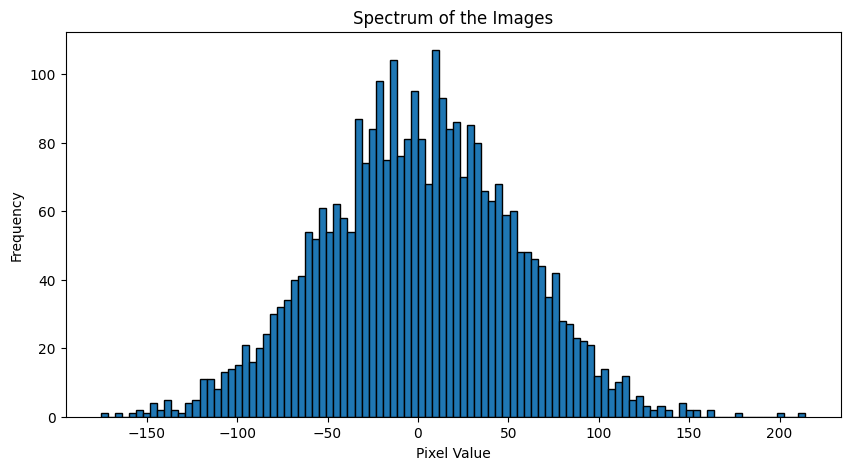

torch.Size([1000, 3, 32, 32])
torch.Size([1000])


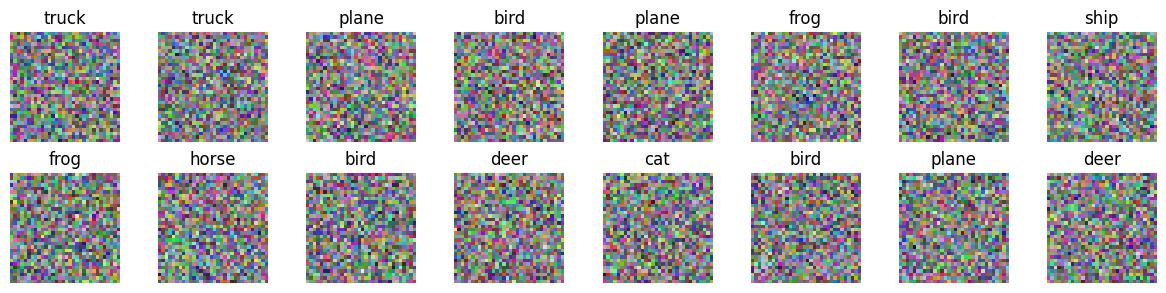

In [40]:
transform_random = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

batches_id = 100
test_images, test_labels = local_dataset_loader(batch_num=10, batches_id=batches_id, verbose=True)

# plot the spectrum of the multiple images
plt.figure(figsize=(10, 5))
plt.hist(test_images[116].flatten(), bins=100, edgecolor='black')
plt.title('Spectrum of the Images')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

print(test_images.shape)
print(test_labels.shape)
plotExampleImages(test_images[32:48, :, :, :].numpy(), test_labels[32:48].tolist())

In [41]:
test_dataset = torch.utils.data.TensorDataset(transform_normalize_0_1(test_images), test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loss, accuracy = test_simple(model, testloader=test_dataloader, verbose=True)
print(loss, accuracy)

NameError: name 'test_simple' is not defined

torch.Size([10000, 3, 32, 32])
torch.Size([10000])


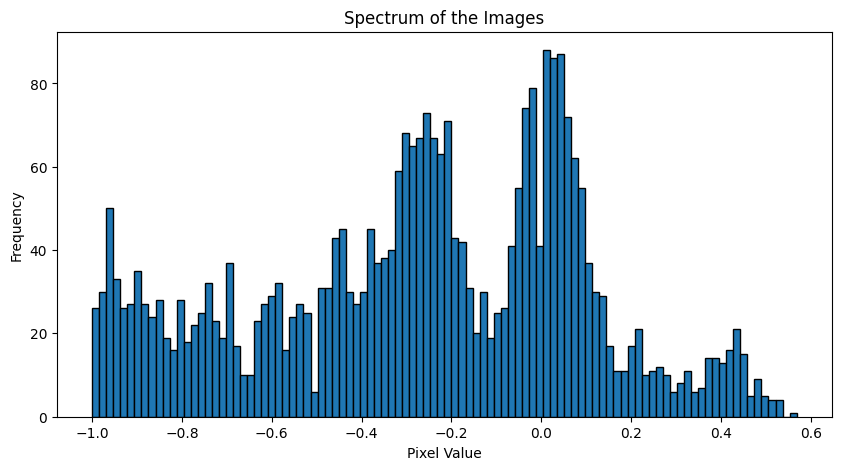

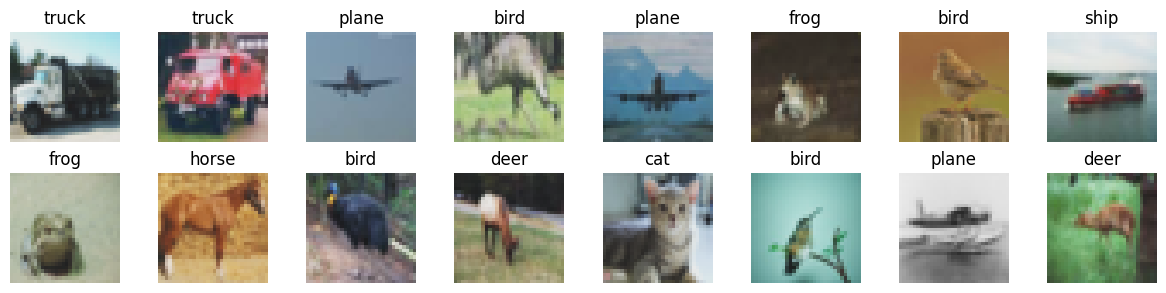

In [156]:
test_images_original, test_labels_original = local_dataset_loader(batch_num=batch_num, batches_id=batches_id, load_original=True)
print(test_images_original.shape)
print(test_labels_original.shape)


plt.figure(figsize=(10, 5))
plt.hist(test_images_original[116].flatten(), bins=100, edgecolor='black')
plt.title('Spectrum of the Images')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

plotExampleImages(test_images_original[32:48, :, :, :].numpy(), test_labels_original[32:48].tolist())

In [157]:
test_dataset = torch.utils.data.TensorDataset(transform_normalize_0_1(test_images_original), test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
loss, accuracy = test_simple(model, testloader=test_dataloader, verbose=True)
print(loss, accuracy)

AssertionError: Size mismatch between tensors

tensor([439])


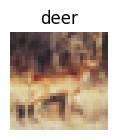

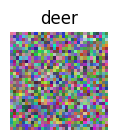

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
[-3008.1045 -2373.3196 -1746.0206 -2362.5166 -2296.6265 -2432.271
  -437.2336 -2857.638   3139.4268  2946.7292]
Batch 439: loss 5436.053, accuracy 0.000


In [164]:
random_batch_id = torch.tensor(np.random.choice(test_labels.shape[0], 1)).to(torch.int64)
print(random_batch_id)

random_images, random_labels = test_images[random_batch_id], test_labels[random_batch_id]
random_images_original, random_labels_original = test_images_original[random_batch_id], test_labels_original[random_batch_id]

plotExampleImages(transform_normalize(random_images_original).reshape((1, 3, 32, 32)).numpy(), random_labels.numpy())
plotExampleImages(transform_normalize(random_images).reshape((1, 3, 32, 32)).numpy(), random_labels.numpy())

classes_list = []
for i in range(len(classes)):
    classes_list.append(classes[i])
print(classes_list)

criterion = torch.nn.CrossEntropyLoss()
model.eval()
with torch.no_grad():
    outputs = model(random_images)
    np.set_printoptions(precision=4, threshold=100)
    print(outputs.data.numpy()[0])
    loss = criterion(outputs, random_labels).item()
    accuracy = (torch.max(outputs.data, 1)[1] == random_labels).sum().item()
    print(f"Batch {random_batch_id.item()}: loss {loss:.3f}, accuracy {accuracy:.3f}")

In [ ]:
# Save the model's state_dict
torch.save(model.state_dict(), "model20.pth")


In [ ]:
# print out the model's structure
print(model)


Model(
  (layer): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Epoch 1, Batch 1: train loss 2.30877, accuracy 4.00000 %
Batch 1: loss 2.31017, accuracy 9.00000 %
Batch 2: loss 2.31343, accuracy 9.50000 %
Batch 3: loss 2.30725, accuracy 12.66667 %
Batch 4: loss 2.34064, accuracy 11.25000 %
Batch 5: loss 2.31718, accuracy 10.40000 %
Batch 6: loss 2.29663, accuracy 11.50000 %
Batch 7: loss 2.30622, accuracy 11.42857 %
Batch 8: loss 2.31974, accuracy 10.62500 %
Batch 9: loss 2.30360, accuracy 11.00000 %
Batch 10: loss 2.29278, accuracy 11.30000 %
Test loss 2.31076, accuracy 11.30000 %
Epoch 1: train loss 2.30354, train accuracy 9.30000 %, val loss 2.31076, val accuracy 11.30000 %
Epoch 2, Batch 1: train loss 2.29513, accuracy 11.00000 %
Batch 1: loss 2.30061, accuracy 12.00000 %
Batch 2: loss 2.31177, accuracy 13.50000 %
Batch 3: loss 2.32258, accuracy 11.33333 %
Batch 4: loss 2.29527, accuracy 11.25000 %
Batch 5: loss 2.29902, accuracy 11.00000 %
Batch 6: loss 2.29870, accuracy 10.66667 %
Batch 7: loss 2.30645, accuracy 10.42857 %
Batch 8: loss 2.30606, accuracy 10.25000 %
Batch 9: loss 2.31089, accuracy 9.66667 %
Batch 10: loss 2.28980, accuracy 10.30000 %
Test loss 2.30412, accuracy 10.30000 %
Epoch 2: train loss 2.28732, train accuracy 16.10000 %, val loss 2.30412, val accuracy 10.30000 %
Epoch 3, Batch 1: train loss 2.27598, accuracy 20.00000 %
Batch 1: loss 2.30121, accuracy 13.00000 %
Batch 2: loss 2.30562, accuracy 11.50000 %
Batch 3: loss 2.29872, accuracy 10.66667 %
Batch 4: loss 2.29345, accuracy 11.75000 %
Batch 5: loss 2.29945, accuracy 11.80000 %
Batch 6: loss 2.29807, accuracy 11.50000 %
Batch 7: loss 2.30964, accuracy 11.00000 %
Batch 8: loss 2.30315, accuracy 11.37500 %
Batch 9: loss 2.31148, accuracy 10.55556 %
Batch 10: loss 2.30505, accuracy 10.90000 %
Test loss 2.30258, accuracy 10.90000 %
Epoch 3: train loss 2.25862, train accuracy 22.50000 %, val loss 2.30258, val accuracy 10.90000 %
Epoch 4, Batch 1: train loss 2.22395, accuracy 32.00000 %
Batch 1: loss 2.29443, accuracy 13.00000 %
Batch 2: loss 2.29269, accuracy 13.00000 %
Batch 3: loss 2.30661, accuracy 12.66667 %
Batch 4: loss 2.30036, accuracy 12.75000 %
Batch 5: loss 2.30274, accuracy 12.40000 %
Batch 6: loss 2.29360, accuracy 12.16667 %
Batch 7: loss 2.33499, accuracy 11.00000 %
Batch 8: loss 2.30145, accuracy 11.00000 %
Batch 9: loss 2.29574, accuracy 11.11111 %
Batch 10: loss 2.30277, accuracy 11.50000 %
Test loss 2.30254, accuracy 11.50000 %
Epoch 4: train loss 2.21003, train accuracy 30.60000 %, val loss 2.30254, val accuracy 11.50000 %
Epoch 5, Batch 1: train loss 2.19346, accuracy 33.00000 %
Batch 1: loss 2.30957, accuracy 10.00000 %
Batch 2: loss 2.30937, accuracy 13.00000 %
Batch 3: loss 2.30145, accuracy 12.33333 %
Batch 4: loss 2.31792, accuracy 12.50000 %
Batch 5: loss 2.30545, accuracy 12.20000 %
Batch 6: loss 2.37586, accuracy 10.50000 %
Batch 7: loss 2.30639, accuracy 10.85714 %
Batch 8: loss 2.33243, accuracy 10.50000 %
Batch 9: loss 2.35899, accuracy 9.88889 %
Batch 10: loss 2.35051, accuracy 9.20000 %
Test loss 2.32679, accuracy 9.20000 %
Epoch 5: train loss 2.15276, train accuracy 39.10000 %, val loss 2.32679, val accuracy 9.20000 %
Epoch 1, Batch 1: train loss 2.10556, accuracy 46.00000 %
Batch 1: loss 2.31849, accuracy 10.00000 %
Batch 2: loss 2.33019, accuracy 7.00000 %
Batch 3: loss 2.32767, accuracy 6.33333 %
Batch 4: loss 2.33013, accuracy 6.75000 %
Batch 5: loss 2.30231, accuracy 7.60000 %
Batch 6: loss 2.32981, accuracy 8.00000 %
Batch 7: loss 2.33061, accuracy 7.57143 %
Batch 8: loss 2.30209, accuracy 7.62500 %
Batch 9: loss 2.29118, accuracy 7.88889 %
Batch 10: loss 2.32191, accuracy 8.10000 %
Test loss 2.31844, accuracy 8.10000 %
Epoch 1: train loss 2.10016, train accuracy 41.10000 %, val loss 2.31844, val accuracy 8.10000 %
Epoch 2, Batch 1: train loss 2.05212, accuracy 49.00000 %
Batch 1: loss 2.31259, accuracy 9.00000 %
Batch 2: loss 2.29794, accuracy 10.00000 %
Batch 3: loss 2.31790, accuracy 9.66667 %
Batch 4: loss 2.30951, accuracy 8.75000 %
Batch 5: loss 2.29964, accuracy 9.00000 %
Batch 6: loss 2.29058, accuracy 9.66667 %
Batch 7: loss 2.31010, accuracy 9.57143 %
Batch 8: loss 2.30081, accuracy 9.12500 %
Batch 9: loss 2.31539, accuracy 8.88889 %
Batch 10: loss 2.32381, accuracy 8.80000 %
Test loss 2.30783, accuracy 8.80000 %
Epoch 2: train loss 2.04739, train accuracy 47.70000 %, val loss 2.30783, val accuracy 8.80000 %
Epoch 3, Batch 1: train loss 1.99011, accuracy 57.00000 %
Batch 1: loss 2.29947, accuracy 12.00000 %
Batch 2: loss 2.31433, accuracy 11.50000 %
Batch 3: loss 2.31956, accuracy 9.66667 %
Batch 4: loss 2.31593, accuracy 9.00000 %
Batch 5: loss 2.30253, accuracy 8.80000 %
Batch 6: loss 2.30641, accuracy 8.83333 %
Batch 7: loss 2.29421, accuracy 9.71429 %
Batch 8: loss 2.27818, accuracy 9.75000 %
Batch 9: loss 2.31835, accuracy 9.55556 %
Batch 10: loss 2.30521, accuracy 10.30000 %
Test loss 2.30542, accuracy 10.30000 %
Epoch 3: train loss 1.97350, train accuracy 57.80000 %, val loss 2.30542, val accuracy 10.30000 %
Epoch 4, Batch 1: train loss 1.94159, accuracy 59.00000 %
Batch 1: loss 2.30949, accuracy 12.00000 %
Batch 2: loss 2.32223, accuracy 11.00000 %
Batch 3: loss 2.31686, accuracy 10.00000 %
Batch 4: loss 2.30257, accuracy 9.50000 %
Batch 5: loss 2.29518, accuracy 9.20000 %
Batch 6: loss 2.32789, accuracy 9.66667 %
Batch 7: loss 2.29642, accuracy 9.85714 %
Batch 8: loss 2.29573, accuracy 10.25000 %
Batch 9: loss 2.31589, accuracy 10.22222 %
Batch 10: loss 2.29001, accuracy 10.90000 %
Test loss 2.30723, accuracy 10.90000 %
Epoch 4: train loss 1.91518, train accuracy 62.40000 %, val loss 2.30723, val accuracy 10.90000 %
Epoch 5, Batch 1: train loss 1.86493, accuracy 66.00000 %
Batch 1: loss 2.34878, accuracy 16.00000 %
Batch 2: loss 2.35682, accuracy 12.00000 %
Batch 3: loss 2.33918, accuracy 10.33333 %
Batch 4: loss 2.29646, accuracy 10.25000 %
Batch 5: loss 2.34574, accuracy 9.20000 %
Batch 6: loss 2.32165, accuracy 9.16667 %
Batch 7: loss 2.32761, accuracy 9.42857 %
Batch 8: loss 2.28511, accuracy 9.87500 %
Batch 9: loss 2.32779, accuracy 9.77778 %
Batch 10: loss 2.33926, accuracy 9.90000 %
Test loss 2.32884, accuracy 9.90000 %
Epoch 5: train loss 1.85353, train accuracy 66.60000 %, val loss 2.32884, val accuracy 9.90000 %
Epoch 1, Batch 1: train loss 1.79901, accuracy 67.00000 %
Batch 1: loss 2.33586, accuracy 8.00000 %
Batch 2: loss 2.29824, accuracy 9.50000 %
Batch 3: loss 2.31386, accuracy 10.00000 %
Batch 4: loss 2.31228, accuracy 10.75000 %
Batch 5: loss 2.31097, accuracy 10.80000 %
Batch 6: loss 2.34668, accuracy 10.50000 %
Batch 7: loss 2.34113, accuracy 9.85714 %
Batch 8: loss 2.28382, accuracy 10.12500 %
Batch 9: loss 2.31662, accuracy 9.77778 %
Batch 10: loss 2.32374, accuracy 9.90000 %
Test loss 2.31832, accuracy 9.90000 %
Epoch 1: train loss 1.81287, train accuracy 65.20000 %, val loss 2.31832, val accuracy 9.90000 %
Epoch 2, Batch 1: train loss 1.77257, accuracy 71.00000 %
Batch 1: loss 2.37447, accuracy 8.00000 %
Batch 2: loss 2.32168, accuracy 10.00000 %
Batch 3: loss 2.32350, accuracy 9.66667 %
Batch 4: loss 2.27734, accuracy 10.25000 %
Batch 5: loss 2.29639, accuracy 10.20000 %
Batch 6: loss 2.33689, accuracy 9.66667 %
Batch 7: loss 2.32169, accuracy 10.28571 %
Batch 8: loss 2.30950, accuracy 10.37500 %
Batch 9: loss 2.35113, accuracy 9.66667 %
Batch 10: loss 2.32344, accuracy 9.90000 %
Test loss 2.32360, accuracy 9.90000 %
Epoch 2: train loss 1.78294, train accuracy 67.50000 %, val loss 2.32360, val accuracy 9.90000 %
Epoch 3, Batch 1: train loss 1.72715, accuracy 66.00000 %
Batch 1: loss 2.33557, accuracy 10.00000 %
Batch 2: loss 2.35786, accuracy 11.50000 %
Batch 3: loss 2.33828, accuracy 11.00000 %
Batch 4: loss 2.31665, accuracy 11.75000 %
Batch 5: loss 2.30603, accuracy 12.00000 %
Batch 6: loss 2.34247, accuracy 12.00000 %
Batch 7: loss 2.32622, accuracy 10.85714 %
Batch 8: loss 2.38679, accuracy 11.25000 %
Batch 9: loss 2.35390, accuracy 10.77778 %
Batch 10: loss 2.34978, accuracy 10.70000 %
Test loss 2.34136, accuracy 10.70000 %
Epoch 3: train loss 1.70061, train accuracy 71.50000 %, val loss 2.34136, val accuracy 10.70000 %
Epoch 4, Batch 1: train loss 1.66823, accuracy 78.00000 %
Batch 1: loss 2.30432, accuracy 7.00000 %
Batch 2: loss 2.31148, accuracy 11.00000 %
Batch 3: loss 2.32244, accuracy 11.00000 %
Batch 4: loss 2.29173, accuracy 12.00000 %
Batch 5: loss 2.32033, accuracy 11.00000 %
Batch 6: loss 2.29901, accuracy 11.33333 %
Batch 7: loss 2.31792, accuracy 12.00000 %
Batch 8: loss 2.29128, accuracy 12.25000 %
Batch 9: loss 2.31896, accuracy 12.00000 %
Batch 10: loss 2.33688, accuracy 12.20000 %
Test loss 2.31143, accuracy 12.20000 %
Epoch 4: train loss 1.63882, train accuracy 77.30000 %, val loss 2.31143, val accuracy 12.20000 %
Epoch 5, Batch 1: train loss 1.59555, accuracy 78.00000 %
Batch 1: loss 2.32498, accuracy 13.00000 %
Batch 2: loss 2.33752, accuracy 11.00000 %
Batch 3: loss 2.33308, accuracy 9.66667 %
Batch 4: loss 2.33072, accuracy 9.50000 %
Batch 5: loss 2.29826, accuracy 10.20000 %
Batch 6: loss 2.31759, accuracy 10.16667 %
Batch 7: loss 2.32909, accuracy 9.71429 %
Batch 8: loss 2.32044, accuracy 9.75000 %
Batch 9: loss 2.30390, accuracy 9.88889 %
Batch 10: loss 2.32351, accuracy 9.70000 %
Test loss 2.32191, accuracy 9.70000 %
Epoch 5: train loss 1.58265, train accuracy 77.80000 %, val loss 2.32191, val accuracy 9.70000 %
Epoch 1, Batch 1: train loss 1.54404, accuracy 84.00000 %
Batch 1: loss 2.35694, accuracy 7.00000 %
Batch 2: loss 2.32117, accuracy 11.50000 %
Batch 3: loss 2.32970, accuracy 11.33333 %
Batch 4: loss 2.33181, accuracy 10.75000 %
Batch 5: loss 2.28371, accuracy 11.40000 %
Batch 6: loss 2.31968, accuracy 11.33333 %
Batch 7: loss 2.30781, accuracy 11.42857 %
Batch 8: loss 2.38084, accuracy 10.37500 %
Batch 9: loss 2.37031, accuracy 10.22222 %
Batch 10: loss 2.32108, accuracy 10.40000 %
Test loss 2.33231, accuracy 10.40000 %
Epoch 1: train loss 1.55047, train accuracy 78.50000 %, val loss 2.33231, val accuracy 10.40000 %
Epoch 2, Batch 1: train loss 1.51712, accuracy 80.00000 %
Batch 1: loss 2.36151, accuracy 10.00000 %
Batch 2: loss 2.32551, accuracy 10.50000 %
Batch 3: loss 2.31101, accuracy 11.00000 %
Batch 4: loss 2.37086, accuracy 10.75000 %
Batch 5: loss 2.32877, accuracy 11.00000 %
Batch 6: loss 2.37569, accuracy 10.16667 %
Batch 7: loss 2.34387, accuracy 10.28571 %
Batch 8: loss 2.32305, accuracy 10.50000 %
Batch 9: loss 2.33181, accuracy 10.33333 %
Batch 10: loss 2.36794, accuracy 10.20000 %
Test loss 2.34400, accuracy 10.20000 %
Epoch 2: train loss 1.53537, train accuracy 73.40000 %, val loss 2.34400, val accuracy 10.20000 %
Epoch 3, Batch 1: train loss 1.47831, accuracy 74.00000 %
Batch 1: loss 2.37292, accuracy 7.00000 %
Batch 2: loss 2.33258, accuracy 8.50000 %
Batch 3: loss 2.33755, accuracy 8.33333 %
Batch 4: loss 2.30390, accuracy 9.00000 %
Batch 5: loss 2.31928, accuracy 9.60000 %
Batch 6: loss 2.28437, accuracy 10.33333 %
Batch 7: loss 2.31177, accuracy 10.28571 %
Batch 8: loss 2.34720, accuracy 9.87500 %
Batch 9: loss 2.34049, accuracy 9.66667 %
Batch 10: loss 2.30379, accuracy 9.90000 %
Test loss 2.32539, accuracy 9.90000 %
Epoch 3: train loss 1.46291, train accuracy 78.90000 %, val loss 2.32539, val accuracy 9.90000 %
Epoch 4, Batch 1: train loss 1.40964, accuracy 83.00000 %
Batch 1: loss 2.39026, accuracy 12.00000 %
Batch 2: loss 2.42195, accuracy 8.50000 %
Batch 3: loss 2.46249, accuracy 8.00000 %
Batch 4: loss 2.38557, accuracy 8.75000 %
Batch 5: loss 2.43295, accuracy 8.80000 %
Batch 6: loss 2.44066, accuracy 9.00000 %
Batch 7: loss 2.41214, accuracy 8.85714 %
Batch 8: loss 2.43111, accuracy 9.25000 %
Batch 9: loss 2.41195, accuracy 9.44444 %
Batch 10: loss 2.43264, accuracy 9.30000 %
Test loss 2.42217, accuracy 9.30000 %
Epoch 4: train loss 1.40561, train accuracy 80.50000 %, val loss 2.42217, val accuracy 9.30000 %
Epoch 5, Batch 1: train loss 1.33770, accuracy 91.00000 %
Batch 1: loss 2.31762, accuracy 11.00000 %
Batch 2: loss 2.38243, accuracy 10.50000 %
Batch 3: loss 2.36709, accuracy 10.33333 %
Batch 4: loss 2.33779, accuracy 9.50000 %
Batch 5: loss 2.31383, accuracy 9.60000 %
Batch 6: loss 2.29665, accuracy 9.66667 %
Batch 7: loss 2.35280, accuracy 10.28571 %
Batch 8: loss 2.33427, accuracy 10.12500 %
Batch 9: loss 2.29594, accuracy 10.22222 %
Batch 10: loss 2.31744, accuracy 9.90000 %
Test loss 2.33159, accuracy 9.90000 %
Epoch 5: train loss 1.34752, train accuracy 83.20000 %, val loss 2.33159, val accuracy 9.90000 %
Epoch 1, Batch 1: train loss 1.28820, accuracy 89.00000 %
Batch 1: loss 2.34442, accuracy 17.00000 %
Batch 2: loss 2.39646, accuracy 13.50000 %
Batch 3: loss 2.36789, accuracy 11.66667 %
Batch 4: loss 2.33770, accuracy 14.00000 %
Batch 5: loss 2.38103, accuracy 13.80000 %
Batch 6: loss 2.40007, accuracy 12.50000 %
Batch 7: loss 2.35962, accuracy 12.28571 %
Batch 8: loss 2.41063, accuracy 12.00000 %
Batch 9: loss 2.44469, accuracy 11.77778 %
Batch 10: loss 2.40105, accuracy 11.80000 %
Test loss 2.38436, accuracy 11.80000 %
Epoch 1: train loss 1.31567, train accuracy 84.20000 %, val loss 2.38436, val accuracy 11.80000 %
Epoch 2, Batch 1: train loss 1.25881, accuracy 83.00000 %
Batch 1: loss 2.42157, accuracy 7.00000 %
Batch 2: loss 2.37568, accuracy 6.50000 %
Batch 3: loss 2.44890, accuracy 7.00000 %
Batch 4: loss 2.43445, accuracy 7.50000 %
Batch 5: loss 2.36607, accuracy 8.40000 %
Batch 6: loss 2.40733, accuracy 8.33333 %
Batch 7: loss 2.35041, accuracy 8.57143 %
Batch 8: loss 2.43244, accuracy 8.00000 %
Batch 9: loss 2.34111, accuracy 8.55556 %
Batch 10: loss 2.35894, accuracy 8.70000 %
Test loss 2.39369, accuracy 8.70000 %
Epoch 2: train loss 1.29655, train accuracy 80.40000 %, val loss 2.39369, val accuracy 8.70000 %
Epoch 3, Batch 1: train loss 1.24295, accuracy 88.00000 %
Batch 1: loss 2.38306, accuracy 13.00000 %
Batch 2: loss 2.35579, accuracy 10.50000 %
Batch 3: loss 2.41873, accuracy 10.66667 %
Batch 4: loss 2.41960, accuracy 10.50000 %
Batch 5: loss 2.40485, accuracy 10.40000 %
Batch 6: loss 2.39345, accuracy 10.33333 %
Batch 7: loss 2.32966, accuracy 10.28571 %
Batch 8: loss 2.32531, accuracy 10.37500 %
Batch 9: loss 2.36479, accuracy 10.33333 %
Batch 10: loss 2.36770, accuracy 9.90000 %
Test loss 2.37629, accuracy 9.90000 %
Epoch 3: train loss 1.23451, train accuracy 81.80000 %, val loss 2.37629, val accuracy 9.90000 %
Epoch 4, Batch 1: train loss 1.16004, accuracy 88.00000 %
Batch 1: loss 2.55661, accuracy 11.00000 %
Batch 2: loss 2.54235, accuracy 10.50000 %
Batch 3: loss 2.45009, accuracy 11.66667 %
Batch 4: loss 2.56825, accuracy 11.50000 %
Batch 5: loss 2.59874, accuracy 10.60000 %
Batch 6: loss 2.60454, accuracy 9.83333 %
Batch 7: loss 2.48017, accuracy 9.85714 %
Batch 8: loss 2.55466, accuracy 10.12500 %
Batch 9: loss 2.56455, accuracy 10.44444 %
Batch 10: loss 2.69790, accuracy 9.90000 %
Test loss 2.56179, accuracy 9.90000 %
Epoch 4: train loss 1.18167, train accuracy 83.60000 %, val loss 2.56179, val accuracy 9.90000 %
Epoch 5, Batch 1: train loss 1.11684, accuracy 91.00000 %
Batch 1: loss 2.40547, accuracy 13.00000 %
Batch 2: loss 2.34842, accuracy 13.50000 %
Batch 3: loss 2.44725, accuracy 11.66667 %
Batch 4: loss 2.38815, accuracy 10.75000 %
Batch 5: loss 2.40261, accuracy 10.00000 %
Batch 6: loss 2.37512, accuracy 10.50000 %
Batch 7: loss 2.38413, accuracy 10.71429 %
Batch 8: loss 2.45196, accuracy 10.00000 %
Batch 9: loss 2.33749, accuracy 10.44444 %
Batch 10: loss 2.41833, accuracy 10.90000 %
Test loss 2.39589, accuracy 10.90000 %
Epoch 5: train loss 1.12865, train accuracy 86.00000 %, val loss 2.39589, val accuracy 10.90000 %


In [ ]:
A, B, C = 5, 4.5, 4
grade = [B,B,B,A,A,A,C,B,C,A,B]
weight = [7.5, 7.5, 7.5, 7.5, 9, 7.5, 7.5, 7.5, 7.5, 3, 7.5]
print(sum([grade[i] * weight[i] for i in range(11)]) / sum(weight))

4.5754716981132075


In [10]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
layer.conv1.weight 	 torch.Size([16, 3, 3, 3])
layer.bn1.weight 	 torch.Size([16])
layer.bn1.bias 	 torch.Size([16])
layer.bn1.running_mean 	 torch.Size([16])
layer.bn1.running_var 	 torch.Size([16])
layer.bn1.num_batches_tracked 	 torch.Size([])
layer.layer1.0.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer.layer1.0.bn1.weight 	 torch.Size([16])
layer.layer1.0.bn1.bias 	 torch.Size([16])
layer.layer1.0.bn1.running_mean 	 torch.Size([16])
layer.layer1.0.bn1.running_var 	 torch.Size([16])
layer.layer1.0.bn1.num_batches_tracked 	 torch.Size([])
layer.layer1.0.conv2.weight 	 torch.Size([16, 16, 3, 3])
layer.layer1.0.bn2.weight 	 torch.Size([16])
layer.layer1.0.bn2.bias 	 torch.Size([16])
layer.layer1.0.bn2.running_mean 	 torch.Size([16])
layer.layer1.0.bn2.running_var 	 torch.Size([16])
layer.layer1.0.bn2.num_batches_tracked 	 torch.Size([])
layer.layer1.1.conv1.weight 	 torch.Size([16, 16, 3, 3])
layer.layer1.1.bn1.weight 	 torch.Size([16])
layer.layer1.1.bn1.bias 	 t